In [1]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from plotting import set_defaults
import pandas as pd
from scipy.optimize import minimize
import random
from sklearn.model_selection import train_test_split
import emcee
import corner
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# -- set the types

kind = "veg"
comp = "new"
runpca = False
runfan = False
runica = False
getndvi = True

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- load the comparison set
print("getting {0} spectra...".format(comp))
blds = np.array([np.load(i) for i in
                 sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs_avg*.npy"\
                                      .format(comp)))])
blds = blds[good]

getting new spectra...


In [5]:
# -- normalize spectra
ms, bs = [], []
for ii in range(blds.shape[0]):
    # m, b = np.polyfit(blds[ii,:100],blds[0,:100],1)
    # m, b = np.polyfit(blds[ii],blds[0],1)
    m = blds[0].mean()/blds[ii].mean()
    b = 0.0
    ms.append(m)
    bs.append(b)

ms   = np.array(ms)
bs   = np.array(bs)
norm = blds*ms[:,np.newaxis] + bs[:,np.newaxis]
rat  = norm/norm[0]

In [6]:
# -- get vegetation spectra
print("getting {0} spectra...".format(kind))
if kind=="veg":
    vegs = np.load("../../../gdobler_output/output/veg_patch_specs.npy")
else:
    vegs = np.array([np.load(i) for i in
                     sorted(glob.glob("../../../gdobler_output/output/" + 
                                      "{0}_specs/{0}_specs_avg*.npy" \
                                      .format(kind)))])
    vegs = vegs[good]

getting veg spectra...


In [7]:
# -- normalize spectra
ss, os = [], []
for ii in range(vegs.shape[0]):
    # s, o = np.polyfit(vegs[ii,:100],vegs[0,:100],1)
    # s, o = np.polyfit(vegs[ii],vegs[0],1)
    s = vegs[0].mean()/vegs[ii].mean()
    o = 0.0
    ss.append(s)
    os.append(o)

ss    = np.array(ss)
os    = np.array(os)
vnorm = vegs*ss[:,np.newaxis] + os[:,np.newaxis]
vrat  = vnorm/vnorm[0]

In [8]:
# -- take the ratio of ratios
brat = vrat/rat

In [9]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [10]:
# -- PCA
if runpca:
    print("running PCA...")
    pca = PCA(n_components=6)
    pca.fit(vrat/rat)
    pamps = pca.transform(vrat/rat)

# -- Factor Analysis
if runfan:
    print("running Factor Analysis...")
    fan = FactorAnalysis(n_components=6)
    fan.fit(vrat/rat)
    famps = fan.transform(vrat/rat)

# -- ICA
if runica:
    print("running ICA...")
    ica = FastICA(n_components=6)
    ica.fit(vrat/rat)
    iamps = ica.transform(vrat/rat)

In [11]:
# -- get NDVI
if getndvi:
    print("calculating NDVI...")
    print("  getting sky spectra...")
    flist   = sorted(glob.glob("../../../gdobler_output/output/sky_specs/*.npy"))
    skys    = np.array([np.load(i) for i in flist])[good]
    print("  getting reflectance...")
    ref     = (vegs - vegs.min(1,keepdims=True))/ \
        (skys-skys.min(1,keepdims=True))
    ind_ir  = np.argmin(np.abs(waves-860.))
    ind_vis = np.argmin(np.abs(waves-670.))
    print("  generating NDVI...")
    ndvi    = (ref[:,ind_ir]-ref[:,ind_vis]) / \
        (ref[:,ind_ir]+ref[:,ind_vis])

calculating NDVI...
  getting sky spectra...
  getting reflectance...
  generating NDVI...


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [78]:
print(waves[500], waves[-150])
print(waves[430], waves[570])

ind_ir  = np.argmin(np.abs(waves-860.))
ind_vis = np.argmin(np.abs(waves-670.))

749.76 895.9
698.89 801.05


In [99]:
# calculate differential ratios

D_750_1000 = brat[:,500] / brat[:,-1]
D_750_900 = brat[:,500] / brat[:,-150]
D_750_900m1000 = brat[:,500] / (brat[:,-150:].mean(1))
D_700m800_900m1000 = (brat[:,430:570].mean(1)) / (brat[:,-150:].mean(1))
D_400m700_700m900 = (brat[:,:424].mean(1)) / (brat[:,424:-150].mean(1))

In [80]:
# create air quality arrays

aq_opth1  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
aq_pth1 = np.vstack([pm25,temps,humid,np.ones_like(o3)]).T
aq_op1 = np.vstack([o3,pm25,np.ones_like(o3)]).T

## Linear Least Squares - no errors

### (1)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [81]:
ind  = np.arange(len(D_750_1000))
sol1  = np.linalg.lstsq(aq_opth1[ind],D_750_1000[ind], rcond=None)
pred1 = np.dot(aq_opth1[ind],sol1[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol1[1] / (len(D_750_1000) * D_750_1000.var())
print("sol = ", sol1)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.57925507e+00, -8.70778400e-03,  6.28846794e-03, -1.40824696e-03,
        7.97202669e-01]), array([30.34580005]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.27087302]


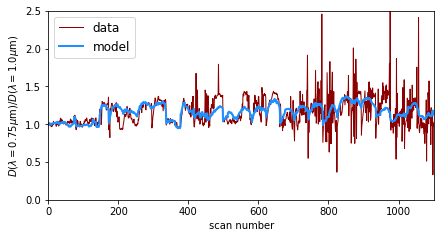

In [82]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_750_1000,color="darkred",lw=1)
linp, = ax.plot(pred1,color="dodgerblue",lw=2)
ax.set_ylim(0,2.5)
ax.set_xlim(0,pred1.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

### (2)  D(750) / D(900)   --||vs||--   O3, PM2.5, Temps, Humid

In [83]:
ind  = np.arange(len(D_750_900))
sol2  = np.linalg.lstsq(aq_opth1[ind],D_750_900[ind], rcond=None)
pred2 = np.dot(aq_opth1[ind],sol2[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol2[1] / (len(D_750_900) * D_750_900.var())
print("sol = ", sol2)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.09678351e+00, -6.38725513e-03,  4.79097804e-03, -9.55834111e-04,
        8.23949547e-01]), array([19.0295201]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.23799599]


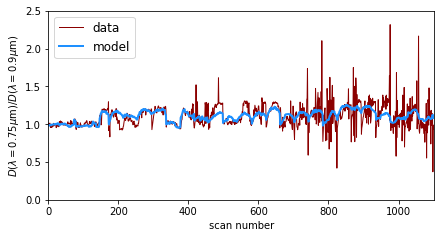

In [84]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_750_900,color="darkred",lw=1)
linp, = ax.plot(pred2,color="dodgerblue",lw=2)
ax.set_ylim(0,2.5)
ax.set_xlim(0,pred2.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

### (3)  D(750) / D(900-1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [85]:
ind  = np.arange(len(D_750_900m1000))
sol3  = np.linalg.lstsq(aq_opth1[ind],D_750_900m1000[ind], rcond=None)
pred3 = np.dot(aq_opth1[ind],sol3[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol3[1] / (len(D_750_900m1000) * D_750_900m1000.var())
print("sol = ", sol3)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.42644174e+00, -8.08638707e-03,  5.98117027e-03, -1.24559272e-03,
        7.96267776e-01]), array([27.05959883]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.26219514]


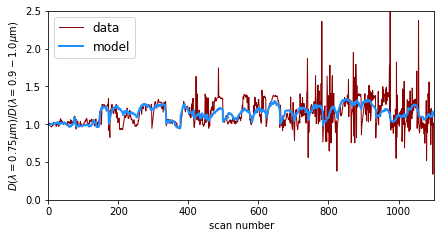

In [86]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_750_900m1000,color="darkred",lw=1)
linp, = ax.plot(pred3,color="dodgerblue",lw=2)
ax.set_ylim(0,2.5)
ax.set_xlim(0,pred3.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

### (4)  D(700-800) / D(900-1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [87]:
ind  = np.arange(len(D_700m800_900m1000))
sol4  = np.linalg.lstsq(aq_opth1[ind],D_700m800_900m1000[ind], rcond=None)
pred4 = np.dot(aq_opth1[ind],sol4[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol4[1] / (len(D_700m800_900m1000) * D_700m800_900m1000.var())
print("sol = ", sol4)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.20600659e+00, -5.47073706e-03,  3.22904300e-03, -8.83306268e-04,
        8.97131022e-01]), array([17.10255064]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.18694919]


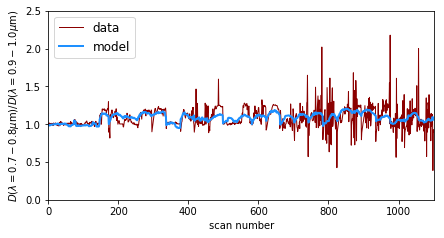

In [88]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_700m800_900m1000,color="darkred",lw=1)
linp, = ax.plot(pred4,color="dodgerblue",lw=2)
ax.set_ylim(0,2.5)
ax.set_xlim(0,pred4.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(\lambda=0.7-0.8\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

### (5)  D(400-700) / D(700-900)   --||vs||--   O3, PM2.5, Temps, Humid

In [89]:
ind  = np.arange(len(D_400m700_700m900))
sol5  = np.linalg.lstsq(aq_opth1[ind],D_400m700_700m900[ind], rcond=None)
pred5 = np.dot(aq_opth1[ind],sol5[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol5[1] / (len(D_400m700_700m900) * D_400m700_700m900.var())
print("sol = ", sol5)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-2.16010484e+00,  1.04972345e-02, -2.00104141e-03,  2.66896932e-03,
        8.80631264e-01]), array([34.09254135]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.6250125]


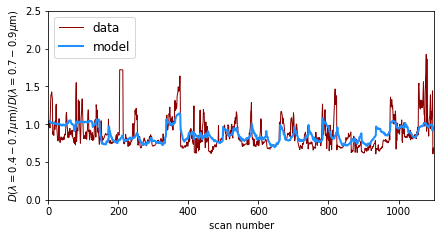

In [177]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_400m700_700m900,color="darkred",lw=1)
linp, = ax.plot(pred5,color="dodgerblue",lw=2)
ax.set_ylim(0,2.5)
ax.set_xlim(0,pred5.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(\lambda=0.4-0.7\mu$m$)/D(\lambda=0.7-0.9\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

#### Plot all together

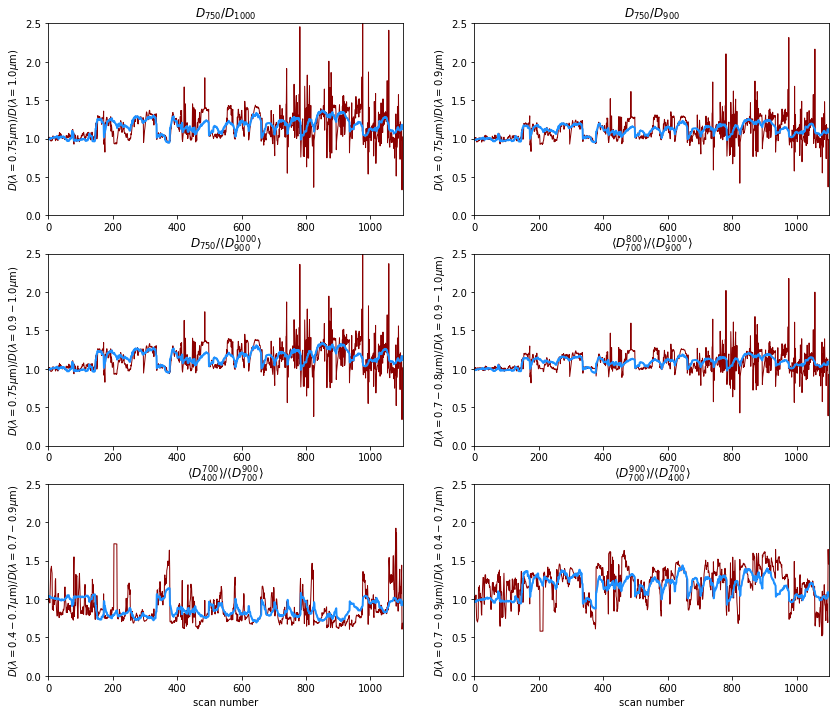

In [179]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

ax1.plot(D_750_1000,color="darkred",lw=1)
ax1.plot(pred1,color="dodgerblue",lw=2)
ax1.set_ylim(0,2.5)
ax1.set_xlim(0,pred1.size)
#ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_title(r'$D_{750}/D_{1000}$')

ax2.plot(D_750_900,color="darkred",lw=1)
ax2.plot(pred2,color="dodgerblue",lw=2)
ax2.set_ylim(0,2.5)
ax2.set_xlim(0,pred2.size)
#ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9\mu$m$)$')
ax2.set_title(r'$D_{750}/D_{900}$')

ax3.plot(D_750_900m1000,color="darkred",lw=1)
ax3.plot(pred3,color="dodgerblue",lw=2)
ax3.set_ylim(0,2.5)
ax3.set_xlim(0,pred3.size)
#ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax3.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax3.set_title(r'$D_{750}/\langle D_{900}^{1000} \rangle$')

ax4.plot(D_700m800_900m1000,color="darkred",lw=1)
ax4.plot(pred4,color="dodgerblue",lw=2)
ax4.set_ylim(0,2.5)
ax4.set_xlim(0,pred4.size)
#ax4.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax4.set_ylabel(r'$D(\lambda=0.7-0.8\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax4.set_title(r'$\langle D_{700}^{800} \rangle/\langle D_{900}^{1000} \rangle$')

ax5.plot(D_400m700_700m900,color="darkred",lw=1)
ax5.plot(pred5,color="dodgerblue",lw=2)
ax5.set_ylim(0,2.5)
ax5.set_xlim(0,pred5.size)
ax5.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax5.set_ylabel(r'$D(\lambda=0.4-0.7\mu$m$)/D(\lambda=0.7-0.9\mu$m$)$')
ax5.set_title(r'$\langle D_{400}^{700} \rangle/\langle D_{700}^{900} \rangle$')

ax6.plot(1/D_400m700_700m900,color="darkred",lw=1)
ax6.plot(1/pred5,color="dodgerblue",lw=2)
ax6.set_ylim(0,2.5)
ax6.set_xlim(0,pred5.size)
ax6.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax6.set_ylabel(r'$D(\lambda=0.7-0.9\mu$m$)/D(\lambda=0.4-0.7\mu$m$)$')
ax6.set_title(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')

plt.show()

### Using Vegetation Indices

In [140]:
ind_ir  = np.argmin(np.abs(waves-860.))
ind_r   = np.argmin(np.abs(waves-670.))
ind_g1   = np.argmin(np.abs(waves-531.))
ind_g2   = np.argmin(np.abs(waves-570.))
ind_b   = np.argmin(np.abs(waves-455.))

In [168]:
# Simple Ratio 
# SR = NIR / R
D_SR = (brat[:,ind_ir] / brat[:,ind_r])

# Normalized Difference Vegetation Index
# NDVI = (NIR - R) / (NIR + R)
D_NDVI = (brat[:,ind_ir] - brat[:,ind_r]) / (brat[:,ind_ir] + brat[:,ind_r])

# Feedback-based, Soil and Atmosphere Resistant Vegetation Index
# SARVI2 = 2.5 * (NIR - Red) / (1 + NIR + (6 * Red) - (7.5 - Blue))
D_SARVI2 = 2.5 * (brat[:,ind_ir] - brat[:,ind_vis]) / (1 + brat[:,ind_ir] + (6 * brat[:,ind_r]) - (7.5 * brat[:,ind_b]))

# Photochemical Reflectance Index
# PRI = (R531 - R570) / (R531 + R570)
D_PRI = (brat[:,ind_g1] - brat[:,ind_g2]) / (brat[:,ind_g1] + brat[:,ind_g2])

### (1)  D(SR)   --||vs||--   O3, PM2.5, Temps, Humid
#### D(SR) = D(NIR) / D(Red)
#### NIR = 860nm, Red = 670nm

In [142]:
ind  = np.arange(len(D_NIR_R))
solSR  = np.linalg.lstsq(aq_opth1[ind],D_SR[ind], rcond=None)
predSR = np.dot(aq_opth1[ind],solSR[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solSR[1] / (len(D_SR) * D_SR.var())
print("sol = ", solSR)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.73280495, -0.01216264,  0.0051659 , -0.00266264,  1.0281735 ]), array([65.17376843]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.19582957]


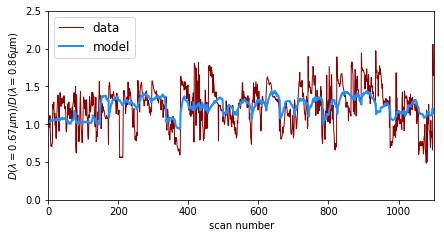

In [143]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_SR,color="darkred",lw=1)
linp, = ax.plot(predSR,color="dodgerblue",lw=2)
ax.set_ylim(0,2.5)
ax.set_xlim(0,predSR.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(\lambda=0.67\mu$m$)/D(\lambda=0.86\mu$m$)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

### (2)  D(NDVI)   --||vs||--   O3, PM2.5, Temps, Humid
#### D(NDVI) = (D(NIR) - D(Red)) / (D(NIR) + D(Red))
#### NIR = 860nm, Red = 670nm

In [144]:
ind  = np.arange(len(D_NDVI))
solNDVI  = np.linalg.lstsq(aq_opth1[ind],D_NDVI[ind], rcond=None)
predNDVI = np.dot(aq_opth1[ind],solNDVI[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solNDVI[1] / (len(D_NDVI) * D_NDVI.var())
print("sol = ", solNDVI)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.04275484, -0.00496768,  0.00166569, -0.00124312,  0.03269888]), array([12.47473037]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.2000958]


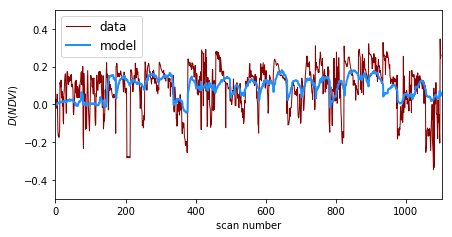

In [146]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_NDVI,color="darkred",lw=1)
linp, = ax.plot(predNDVI,color="dodgerblue",lw=2)
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,predNDVI.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(NDVI)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

### (3)  D(SARVI2)   --||vs||--   O3, PM2.5, Temps, Humid
#### D(SARVI2) = 2.5 * (D(NIR) - D(Red)) / (1 + D(NIR) + (6 * D(Red)) - (7.5 - D(Blue)))
#### NIR = 860nm, Red = 670nm, Blue = 455nm

In [147]:
ind  = np.arange(len(D_SARVI2))
solSARVI2  = np.linalg.lstsq(aq_opth1[ind],D_SARVI2[ind], rcond=None)
predSARVI2 = np.dot(aq_opth1[ind],solSARVI2[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solSARVI2[1] / (len(D_SARVI2) * D_SARVI2.var())
print("sol = ", solSARVI2)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.20975985e+03,  5.02694080e-01, -1.45709286e+00, -2.71935332e-01,
        6.23497162e+01]), array([42158433.80196587]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.00561645]


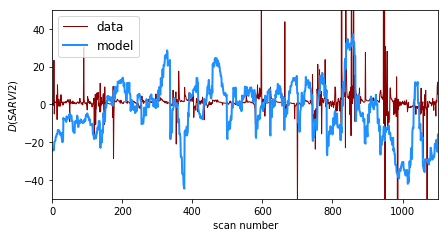

In [167]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_SARVI2,color="darkred",lw=1)
linp, = ax.plot(predSARVI2,color="dodgerblue",lw=2)
ax.set_ylim(-50,50)
ax.set_xlim(0,predSARVI2.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(SARVI2)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

### (4)  D(PRI)   --||vs||--   O3, PM2.5, Temps, Humid
#### D(PRI) = (D(531) - D(570)) / (D(531) + D(570))

In [169]:
ind  = np.arange(len(D_PRI))
solPRI  = np.linalg.lstsq(aq_opth1[ind],D_PRI[ind], rcond=None)
predPRI = np.dot(aq_opth1[ind],solPRI[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - solPRI[1] / (len(D_PRI) * D_PRI.var())
print("sol = ", solPRI)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([-1.19469162e-01,  5.67141726e-04,  5.67589248e-04,  1.11704903e-04,
       -2.69317160e-02]), array([0.05440244]), 5, array([2.95897872e+03, 8.06150599e+02, 1.03971329e+02, 3.26939561e+00,
       2.67971129e-01]))
r2  =  [0.37836557]


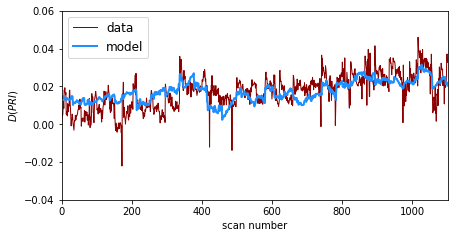

In [171]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(D_PRI,color="darkred",lw=1)
linp, = ax.plot(predPRI,color="dodgerblue",lw=2)
ax.set_ylim(-0.04,0.06)
ax.set_xlim(0,predPRI.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$D(PRI)$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

#### Plot all indices together

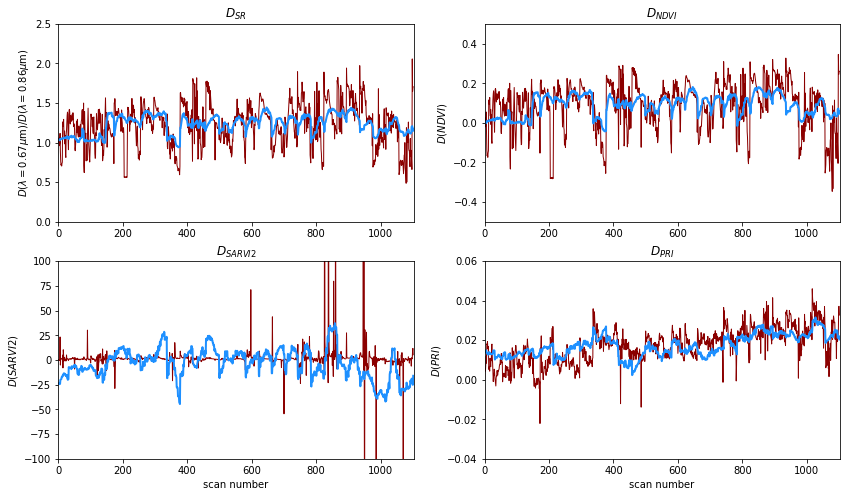

In [172]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,8))

ax1.plot(D_SR,color="darkred",lw=1)
ax1.plot(predSR,color="dodgerblue",lw=2)
ax1.set_ylim(0,2.5)
ax1.set_xlim(0,predSR.size)
#ax1.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax1.set_ylabel(r'$D(\lambda=0.67\mu$m$)/D(\lambda=0.86\mu$m$)$')
ax1.set_title(r'$D_{SR}$')

ax2.plot(D_NDVI,color="darkred",lw=1)
ax2.plot(predNDVI,color="dodgerblue",lw=2)
ax2.set_ylim(-0.5,0.5)
ax2.set_xlim(0,predNDVI.size)
#ax2.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax2.set_ylabel(r'$D(NDVI)$')
ax2.set_title(r'$D_{NDVI}$')

ax3.plot(D_SARVI2,color="darkred",lw=1)
ax3.plot(predSARVI2,color="dodgerblue",lw=2)
ax3.set_ylim(-100,100)
ax3.set_xlim(0,predSARVI2.size)
ax3.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax3.set_ylabel(r'$D(SARVI2)$')
ax3.set_title(r'$D_{SARVI2}$')

ax4.plot(D_PRI,color="darkred",lw=1)
ax4.plot(predPRI,color="dodgerblue",lw=2)
ax4.set_ylim(-0.04,0.06)
ax4.set_xlim(0,predPRI.size)
ax4.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax4.set_ylabel(r'$D(PRI)$')
ax4.set_title(r'$D_{PRI}$')

plt.show()

## Maximum Likelihood Estimation with NDVI

$NDVI = m_{O_3} * O_3 + m_{PM2.5} * PM2.5 + m_{temp} * temp + m_{humid} * humid + b$

uncertainty in brightness obtained using difference of neighbors

assuming the quoted uncertainty is underestimated by a constant amount $f$

In [180]:
# -- obtaining uncertainty for brightness
#brightness = brat[:,500]/brat[:,-1]
brightness = D_NDVI
diff = brightness[1:] - brightness[:-1]
berr = diff.std()/np.sqrt(2.0)
print("error in NDVI = ", berr)

error in NDVI =  0.054307644530871745


In [181]:
# -- obtaining uncertainty for air quality
templates  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

errors in air qaulity =  [2.50960907e-03 7.69473073e-01 1.30383320e+00 2.97720678e+00
 0.00000000e+00]


In [182]:
brightness_err = np.full(brightness.shape, berr)
o3err = np.full(brightness.shape, air_err[0])
pm25err = np.full(brightness.shape, air_err[1])
temperr = np.full(brightness.shape, air_err[2])
humiderr = np.full(brightness.shape, air_err[3])
alphaerr = np.full(brightness.shape, air_err[4])
terr = np.vstack([o3err,pm25err,temperr,humiderr,alphaerr]).T

In [198]:
def log_prior(theta):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, temps, humid, y):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, temps, humid, y)

In [184]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(solNDVI[0], berr)
result = minimize(nll, initial, args=(templates[:,0], templates[:,1], templates[:,2], 
                                    templates[:,3], brightness))
beta_o3_ml, beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("beta_o3 = {0:.5f}".format(beta_o3_ml))
print("beta_pm25 = {0:.5f}".format(beta_pm25_ml))
print("beta_temps = {0:.5f}".format(beta_temps_ml))
print("beta_humid = {0:.5f}".format(beta_humid_ml))
print("alpha = {0:.5f}".format(alpha_ml))
print("epsilon = {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
beta_o3 = 1.04304
beta_pm25 = -0.00497
beta_temps = 0.00167
beta_humid = -0.00124
alpha = 0.03272
epsilon = 0.10640


#### split sample into 80% training and 20% testing

In [185]:
from sklearn.model_selection import train_test_split

aq_tr, aq_te, ndvi_tr, ndvi_te = train_test_split(templates, brightness, test_size=0.2, random_state=314)

In [194]:
print("total # of instances: ", len(brightness))
print("# training instances: ", len(ndvi_tr))
print("# testing instances : ", len(ndvi_te))
print("# features (incl. 1): ", aq_tr.shape[1])

total # of instances:  1102
# training instances:  881
# testing instances :  221
# features (incl. 1):  5


## MCMC

$brightness = m_{O_3} * O_3 + m_{PM2.5} * PM2.5 + m_{temp} * temp + m_{humid} * humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, epsilon, number_of_observations)

In [195]:
nwalkers, ndim = 50, 6
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [199]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
                                                              aq_tr[:,1],
                                                              aq_tr[:,2],
                                                              aq_tr[:,3],
                                                              ndvi_tr))
pos, prob, state = sampler.run_mcmc(p0, 5000)

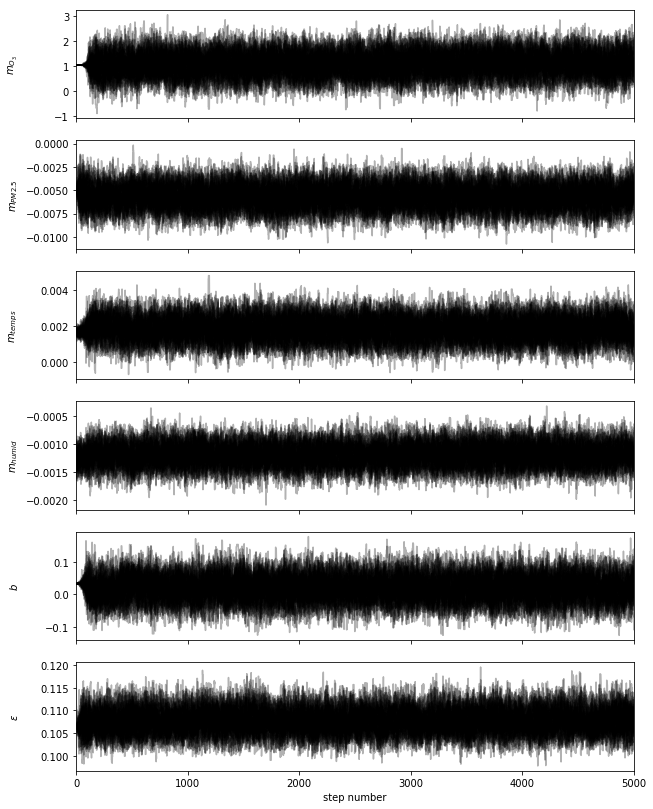

In [200]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
samples = sampler.get_chain()
labels = [r'$m_{O_3}$', r'$m_{PM2.5}$', r'$m_{temps}$', r'$m_{humid}$', r'$b$', r'$\epsilon$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [201]:
tau = sampler.get_autocorr_time()
print(tau)

[66.22979361 66.57918194 55.13864191 58.71524825 53.29960953 59.24432429]


In [202]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)
print(flat_samples.shape)

(8000, 6)


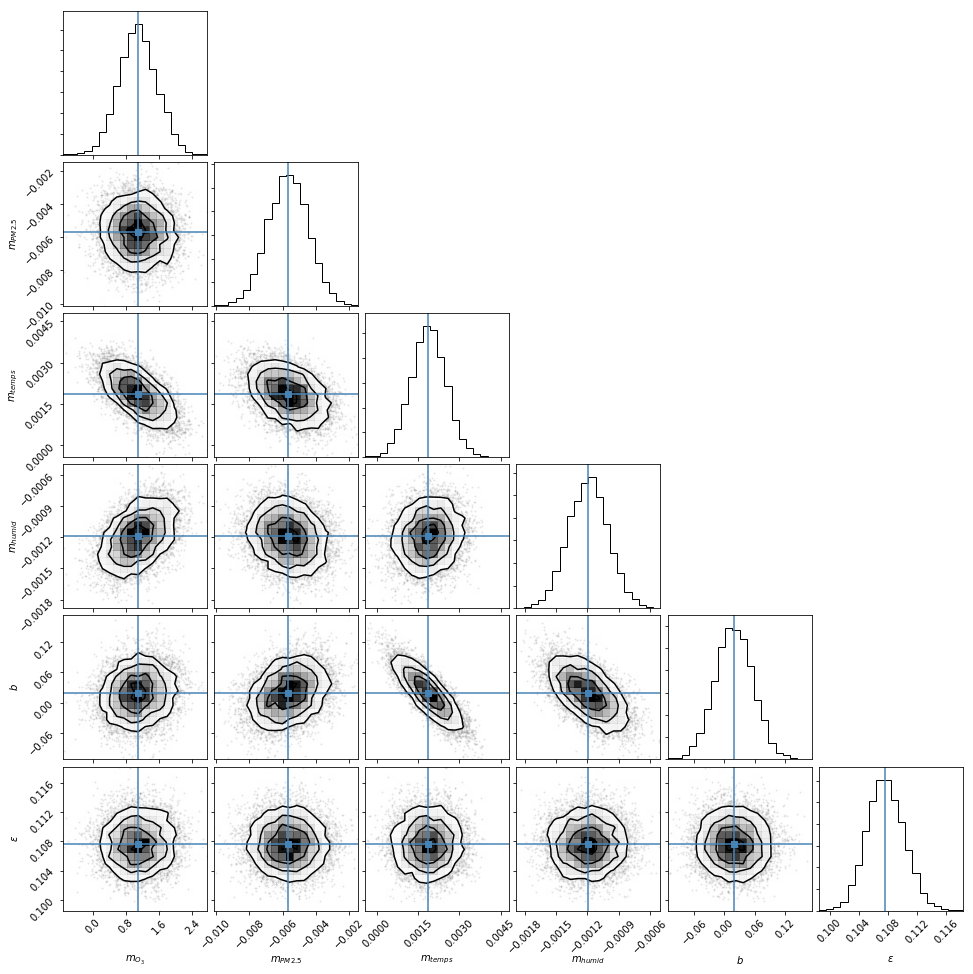

In [203]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [204]:
from IPython.display import display, Math

labels = ["m_{O_3}", "m_{PM2.5}", "m_{temps}", "m_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

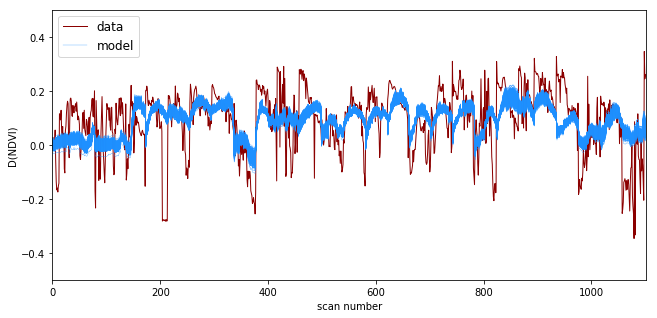

In [206]:
fig, ax = plt.subplots(figsize=[10,5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = plt.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(templates, sample[:5]), color="dodgerblue", lw=0.3)
ax.set_ylim(-0.5,0.5)
ax.set_xlim(0,pred.size)
ax.set_xlabel("scan number")
ax.set_ylabel('D(NDVI)')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [207]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(6)
err_vals = np.zeros(6)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[ 1.08014733 -0.00567052  0.00187048 -0.00119222  0.01860046  0.10760424]
[4.54275077e-01 1.20544303e-03 6.27725952e-04 1.88741660e-04
 3.71254886e-02 2.54179976e-03]


In [210]:
# calculate prediction and uncertainty
pred_tr = np.dot(aq_tr, mvals[:5])
pred_te = np.dot(aq_te, mvals[:5])
pred_tr_err = np.zeros(pred_tr.shape)
pred_te_err = np.zeros(pred_te.shape)

def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

for i in range(aq_tr.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_tr[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_tr[i,1], air_err[1])
    mt_err = err_mult(mvals[2], err_vals[2], aq_tr[i,2], air_err[2])
    mh_err = err_mult(mvals[3], err_vals[3], aq_tr[i,3], air_err[3])
    pred_tr_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[4]]))

for i in range(aq_te.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_te[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_te[i,1], air_err[1])
    mt_err = err_mult(mvals[2], err_vals[2], aq_te[i,2], air_err[2])
    mh_err = err_mult(mvals[3], err_vals[3], aq_te[i,3], air_err[3])
    pred_te_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[4]]))

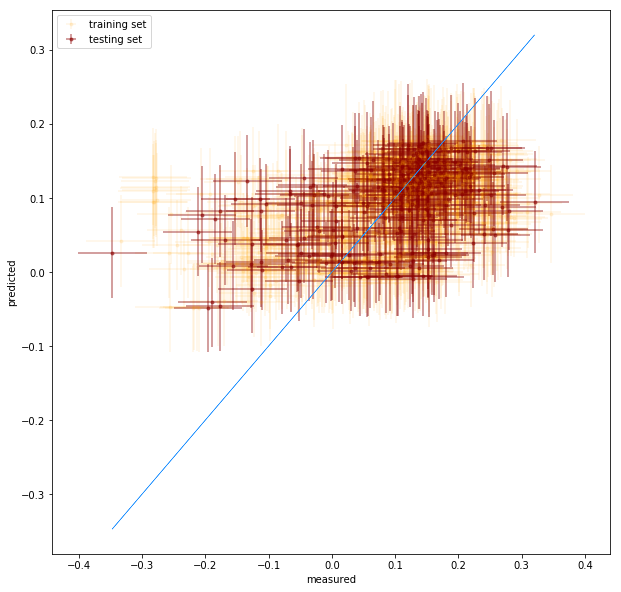

In [220]:
fig = plt.subplots(figsize=[10, 10])
linetr = plt.errorbar(ndvi_tr, pred_tr, xerr=np.full(ndvi_tr.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="orange", alpha=0.1)
linete = plt.errorbar(ndvi_te, pred_te, xerr=np.full(ndvi_te.shape, berr), 
                      yerr=pred_te_err, fmt='.', color="darkred", alpha=0.5)
linlin, = plt.plot(ndvi_te, ndvi_te, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()